In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 16 13:26:00 2019

@author: tealeeseng
"""
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"; # for GPU 1.
import pathlib
# import warnings
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

pixel = 128
batch_size = 128
epoch_size = 100

datatype = 'data-full'
modelname = f'model/full_resnet_sample_b{str(batch_size)}_e{str(epoch_size)}'

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def resLyr(inputs,
           numFilters=16,
           kernelSize=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters,
                     kernel_size=kernelSize,
                     strides=strides,
                     padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4),
                     name=lyrName + '_conv' if lyrName else None)

    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)

        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)

        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
        x = convLyr(x)

    return x

In [3]:
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=4,
             downSampleOnFirst=True,
             names=None):
    x = inputs
    for run in range(0, numBlocks):
        strides = 1
        blkStr = str(run + 1)
        if downSampleOnFirst and run == 0:
            strides = 2

        y = resLyr(inputs=x,
                   numFilters=numFilters,
                   strides=strides,
                   lyrName=names + '_Blk' + blkStr + '_Res1' if names else None)
        y = resLyr(inputs=y,
                   numFilters=numFilters,
                   activation=None,
                   lyrName=names + '_Blk' + blkStr + '_Res2' if names else None)

        if downSampleOnFirst and run == 0:
            x = resLyr(inputs=x,
                       numFilters=numFilters,
                       kernelSize=1,
                       strides=strides,
                       activation=None,
                       batchNorm=False,
                       lyrName=names + '_Blk' + blkStr + '_lin' if names else None)

        x = add([x, y],
                name=names + '_Blk' + blkStr + '_add' if names else None)

        x = Activation('relu', name=names + '_Blk' + blkStr + '_relu' if names else None)(x)

    return x

In [4]:
def createResNetV1(inputShape=(128, 128, 3), numberClasses=3):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, numFilters=16, kernelSize=5, lyrName='Inpt')
    v = resBlkV1(inputs=v,
                 numFilters=16,
                 numBlocks=5,
                 downSampleOnFirst=False,
                 names='Stg1')
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=5,
                 downSampleOnFirst=True,
                 names='Stg2')
    v = resBlkV1(inputs=v,
                 numFilters=64,
                 numBlocks=5,
                 downSampleOnFirst=True,
                 names='Stg3')

    v = AveragePooling2D(pool_size=8,
                         name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numberClasses,
                    activation='softmax',
                    kernel_initializer='he_normal')(v)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.002),
                  metrics=['accuracy'])
    return model


In [5]:
def createModel(target_size=(128, 128)):
    model = createResNetV1(inputShape=(target_size[0], target_size[1], 3))

    return model

In [6]:
# Setup the models
def printSample(all_image_paths):
    img_path = all_image_paths[0]
    image_path = img_path
    img_raw = tf.io.read_file(img_path)
    # print(repr(img_raw)[:100]+' ...')
    img_tensor = tf.image.decode_png(img_raw, channels=3)
    img_tensor = tf.image.resize_image_with_crop_or_pad(img_tensor, 128, 128)
    print(img_tensor.shape, ' ', img_tensor.dtype)
    # for n in range(3):
    #     image_path = random.choice(all_image_paths)
    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()
    # display.display(display.Image(image_path))
    # print(caption_image(image_path))
    # print(matplotlib.get_backend())
    img_final = tf.image.resize(img_tensor, [128, 128])
    img_final = tf.cast(img_final, tf.float32)
    img_final = img_final / 255.0
    print(img_final.shape, ' ', img_final.numpy().min(), ' ', img_final.numpy().max())

In [7]:
def lrSchedule(epoch):
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 140:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1

    print('Learning rate:', lr)
    return lr

In [8]:
target_size = (pixel, pixel)
seed = 29


tdf = pd.read_csv(datatype+"_train_set.csv")
vdf = pd.read_csv(datatype+"_v_set.csv")


In [9]:
model = createModel(target_size)
print('model summary:', model.summary())

filepath = modelname + ".hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode='max')

# Log the epoch detail into csv
csv_logger = CSVLogger(modelname + '.csv')
# callbacks_list  = [checkpoint,csv_logger]

LRScheduler = LearningRateScheduler(lrSchedule)
callbacks_list = [checkpoint, csv_logger, LRScheduler]

datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    zoom_range=0.10,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

vdatagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    width_shift_range=0,
    height_shift_range=0,
    rotation_range=0,
    zoom_range=0,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=tdf, x_col="filename", y_col="label",
                                              class_mode="categorical", target_size=target_size,
                                              shuffle=True,
                                              batch_size=batch_size)

valid_generator = vdatagen.flow_from_dataframe(dataframe=vdf, x_col="filename", y_col="label",
                                               class_mode="categorical", target_size=target_size,
                                               shuffle=True,
                                               batch_size=batch_size)
print(tdf)
print(vdf)
print(train_generator)
print(valid_generator)
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=epoch_size,
                    verbose=1,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=callbacks_list,
                    workers=5,
                    use_multiprocessing=True)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 128, 128, 16) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 128, 128, 16) 64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 128, 128, 16) 0           Inpt_bn[0][0]                    
______________________________________________________________________________________________

Learning rate: 0.001
Epoch 1/100
35/35 [==============================] - 43s 1s/step - loss: 0.5140 - acc: 0.9533 - val_loss: 294.8673 - val_acc: 0.3992
Learning rate: 0.001
Epoch 2/100
35/35 [==============================] - 31s 892ms/step - loss: 0.2498 - acc: 0.9995 - val_loss: 17.0143 - val_acc: 0.6047
Learning rate: 0.001
Epoch 3/100
35/35 [==============================] - 31s 898ms/step - loss: 0.2448 - acc: 1.0000 - val_loss: 2.2246 - val_acc: 0.7391
Learning rate: 0.001
Epoch 4/100
35/35 [==============================] - 32s 904ms/step - loss: 0.2411 - acc: 1.0000 - val_loss: 0.4096 - val_acc: 0.9578
Learning rate: 0.001
Epoch 5/100
35/35 [==============================] - 32s 909ms/step - loss: 0.2377 - acc: 0.9998 - val_loss: 0.2616 - val_acc: 0.9914
Learning rate: 0.001
Epoch 6/100
35/35 [==============================] - 31s 881ms/step - loss: 0.2335 - acc: 1.0000 - val_loss: 0.2316 - val_acc: 1.0000
Learning rate: 0.001
Epoch 7/100
35/35 [==============================

In [10]:
model.save(modelname + '.h5')

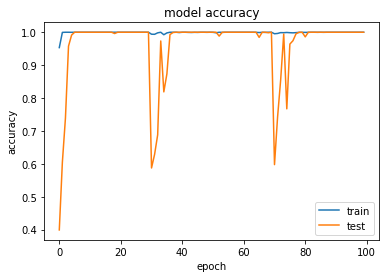

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()